_SPATIAL & GEOMETRY OPERATION ON VECTOR DATA_
**Objetivo general**
Seleccionar la mejor zona de produccioón dentro del territorio colombiano para implementar un proyecto específico, a partir de un análisis espacial multicriterio desarrollado en dos niveles: municipal y local.
**Objetivos específicos**
Realizar un análisis multicriterio a nivel municipal para clasificar los municipios de Colombia, utilizando variables como:
-Producción total EVA por municipio.
-Número de estaciones meteorológicas IDEAM.
-Seleccionar el municipio más apto en función del índice combinado obtenido mediante la normalización y ponderación de criterios relevantes.
-Aplicar un análisis espacial detallado dentro del municipio seleccionado, evaluando criterios locales por celdas regulares (rejilla), como:
°Densidad vial (longitud de vías por celda).
°Cercanía a estaciones IDEAM.
°Lejanía de drenajes como proxy de riesgo de inundación.
°Identificar una zona óptima de hasta 5 km² dentro del municipio más apto, libre de zonas de riesgo, que maximice el cumplimiento de los criterios definidos.
Elaborar salidas cartográficas y un markdown que consolide los resultados obtenidos, incluyendo el municipio seleccionado, la zona propuesta y los criterios utilizados.

Este primer codigo : Este código realiza un análisis espacial para calcular el número de estaciones IDEAM por municipio en Colombia. Primero, carga el shapefile de municipios y lo reproyecta al sistema de referencia EPSG:9377. Luego, lee un archivo CSV con las estaciones IDEAM, extrae las coordenadas desde una cadena de texto, las convierte a puntos geográficos y reproyecta al mismo CRS.Despues realiza una unión espacial con sjoin entre las estaciones y los municipios para identificar en qué municipio se encuentra cada estación. Finalmente, agrupa el número de estaciones por municipio, completa los valores faltantes con cero y genera una tabla final con el nombre y código de municipio y el conteo de estaciones. Esta tabla permite visualizar cuántas estaciones meteorológicas tiene cada municipio.

In [2]:
##  Librerías básicas
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx
import shapely
import os
from IPython.display import display
## aqui se leen los archivos y se reproyectan a 9377 todos para que coincidan
ruta_carpeta = "/notebooks/datos/GIS_Programming_Data"
shp_path = os.path.join(ruta_carpeta, "municipios_colombia.shp")
gdf_municipios = gpd.read_file(shp_path)
gdf_municipios = gdf_municipios.to_crs(epsg=9377)
csv_path = os.path.join(ruta_carpeta, "Catalogo_Estaciones_IDEAM.csv")
df = pd.read_csv(csv_path)

# aqui como ubicacion estan las coordenadas de latitud y longitud las extraemos
df[['latitud', 'longitud']] = df['Ubicación'].str.extract(r'\(?\s*([-\d.]+)\s*,\s*([-\d.]+)\s*\)?')
df['latitud'] = pd.to_numeric(df['latitud'], errors='coerce')
df['longitud'] = pd.to_numeric(df['longitud'], errors='coerce')

#  creamos el dataframe y realizamos el sjoin y agrupamos con el codigo del municipio para luego unir con el dataframe original
gdf_ideam = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['longitud'], df['latitud']), crs="EPSG:4326")
gdf_ideam = gdf_ideam.to_crs(gdf_municipios.crs)
gdf_union = gpd.sjoin(gdf_ideam, gdf_municipios, predicate="within", how="left")
print(gdf_union.columns.tolist())
col_codigo_mpio = [col for col in gdf_union.columns if 'Codigo_Mun' in col][0]
estaciones_por_mpio = gdf_union.groupby(col_codigo_mpio).size().reset_index(name='num_estaciones')
gdf_resultado = gdf_municipios.merge(estaciones_por_mpio, left_on='Codigo_Mun', right_on=col_codigo_mpio, how='left')
gdf_resultado['num_estaciones'] = gdf_resultado['num_estaciones'].fillna(0).astype(int)

# este para imprimir la tabla resultado
tabla_final = gdf_resultado[['Codigo_Mun', 'MPIO_CDPMP', 'MPIO_CNMBR', 'num_estaciones']]
display(tabla_final.sort_values('num_estaciones', ascending=False))

['Codigo', 'Nombre', 'Categoria', 'Estado', 'Departamento', 'Municipio', 'Ubicación', 'Altitud', 'Fecha_instalacion', 'Fecha_suspension', 'Corriente', 'latitud', 'longitud', 'geometry', 'index_right', 'DPTO_CCDGO', 'MPIO_CCDGO', 'MPIO_CNMBR', 'MPIO_CDPMP', 'VERSION', 'AREA', 'LATITUD', 'LONGITUD', 'STCTNENCUE', 'STP3_1_SI', 'STP3_2_NO', 'STP3A_RI', 'STP3B_TCN', 'STP4_1_SI', 'STP4_2_NO', 'STP9_1_USO', 'STP9_2_USO', 'STP9_3_USO', 'STP9_4_USO', 'STP9_2_1_M', 'STP9_2_2_M', 'STP9_2_3_M', 'STP9_2_4_M', 'STP9_2_9_M', 'STP9_3_1_N', 'STP9_3_2_N', 'STP9_3_3_N', 'STP9_3_4_N', 'STP9_3_5_N', 'STP9_3_6_N', 'STP9_3_7_N', 'STP9_3_8_N', 'STP9_3_9_N', 'STP9_3_10', 'STP9_3_99', 'STVIVIENDA', 'STP14_1_TI', 'STP14_2_TI', 'STP14_3_TI', 'STP14_4_TI', 'STP14_5_TI', 'STP14_6_TI', 'STP15_1_OC', 'STP15_2_OC', 'STP15_3_OC', 'STP15_4_OC', 'TSP16_HOG', 'STP19_EC_1', 'STP19_ES_2', 'STP19_EE_1', 'STP19_EE_2', 'STP19_EE_3', 'STP19_EE_4', 'STP19_EE_5', 'STP19_EE_6', 'STP19_EE_9', 'STP19_ACU1', 'STP19_ACU2', 'STP19_ALC1

,Codigo_Mun,MPIO_CDPMP,MPIO_CNMBR,num_estaciones
908,11001,11001,"BOGOTÁ, D.C.",327
229,17001,17001,MANIZALES,93
77,76520,76520,PALMIRA,92
58,76001,76001,CALI,84
868,54001,54001,SAN JOSÉ DE CÚCUTA,73
...,...,...,...,...
663,15401,15401,LA VICTORIA,0
126,52215,52215,CÓRDOBA,0
119,52694,52694,SAN PEDRO DE CARTAGO,0
128,52019,52019,ALBÁN,0


Este bloque de código carga el archivo CSV "Evaluaciones_Agropecuarias_Municipales_EVA.csv" que contiene datos de producción agrícola por municipio, limpia los nombres de las columnas eliminando espacios y saltos de línea, y renombra dos columnas clave: 'CÓD. MUN.' como 'Codigo_Municipio' y 'Producción (t)' como 'production'. Luego, agrupa la información por municipio 'Codigo_Municipio' y suma la producción total en toneladas para cada uno, generando un nuevo DataFrame llamado eva_total con dos columnas: el código del municipio y su producción total. Finalmente, se imprimen los nombres de las columnas para verificar que se haya hecho correctamente el proceso de limpieza. Este resultado se usará como uno de los criterios del análisis multicriterio del proyecto.

In [3]:
## cargamos EVA y agregamos el resultado de la produccion total calculada por municipio y hacemos algunos ajustes de eliminar espacios y saltos d elinea
archivo_csv = os.path.join(ruta_carpeta, "Evaluaciones_Agropecuarias_Municipales_EVA.csv")
df_eva = pd.read_csv(archivo_csv)
df_eva.columns = df_eva.columns.str.replace('\n', ' ').str.strip()
print(df_eva.columns.tolist())
df_eva = df_eva.rename(columns={
    'CÓD. MUN.': 'Codigo_Municipio',
    'Producción (t)': 'production'
})
eva_total = df_eva.groupby('Codigo_Municipio')['production'].sum().reset_index(name='produccion_total')
print(df_eva.columns.tolist())

['CÓD.  DEP.', 'DEPARTAMENTO', 'CÓD. MUN.', 'MUNICIPIO', 'GRUPO  DE CULTIVO', 'SUBGRUPO  DE CULTIVO', 'CULTIVO', 'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO', 'AÑO', 'PERIODO', 'Área Sembrada (ha)', 'Área Cosechada (ha)', 'Producción (t)', 'Rendimiento (t/ha)', 'ESTADO FISICO PRODUCCION', 'NOMBRE  CIENTIFICO', 'CICLO DE CULTIVO']
['CÓD.  DEP.', 'DEPARTAMENTO', 'Codigo_Municipio', 'MUNICIPIO', 'GRUPO  DE CULTIVO', 'SUBGRUPO  DE CULTIVO', 'CULTIVO', 'DESAGREGACIÓN REGIONAL Y/O SISTEMA PRODUCTIVO', 'AÑO', 'PERIODO', 'Área Sembrada (ha)', 'Área Cosechada (ha)', 'production', 'Rendimiento (t/ha)', 'ESTADO FISICO PRODUCCION', 'NOMBRE  CIENTIFICO', 'CICLO DE CULTIVO']


El siguiente codigo realiza la integración final de datos espaciales por municipio y genera dos mapas temáticos. Primero, elimina columnas duplicadas ('produccion_total' y 'Codigo_Municipio') si existían de un merge anterior. Luego, cuenta el número de estaciones IDEAM por municipio ('num_estaciones') y une ese conteo al GeoDataFrame original de municipios (gdf_municipios). También se hace un merge con el DataFrame eva_total que contiene la producción agrícola total por municipio, y se asignan ceros en los casos donde no hay datos. Finalmente, se generan dos mapas: uno que visualiza el número de estaciones IDEAM por municipio usando una escala de color verde-azul, y otro que muestra la producción total EVA por municipio con una escala de color naranja-rojo. Ambos mapas ocultan los ejes y agregan una leyenda para facilitar la interpretación.

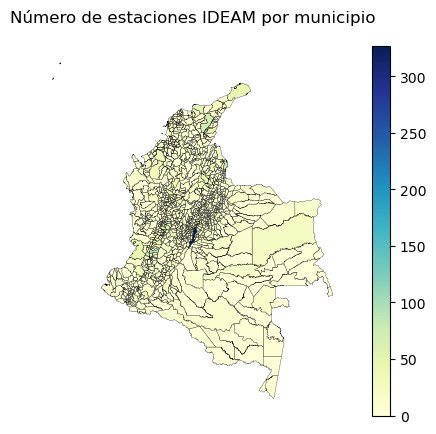

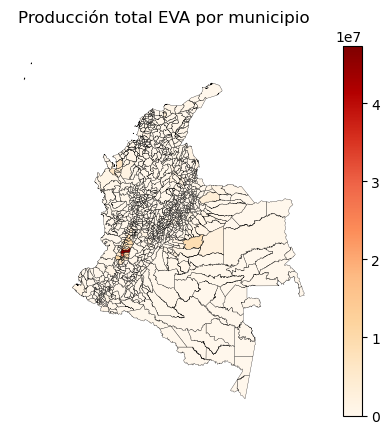

In [4]:
## En este realizamos la unión por municipios eliminando columnas anteriores si existen, contamos las estaciones por municipio y unirmos al DF original
gdf_municipios = gdf_municipios.drop(columns=['produccion_total', 'Codigo_Municipio'], errors='ignore')
estaciones_por_mpio = gdf_union.groupby('Codigo_Mun').size().reset_index(name='num_estaciones')
gdf_municipios = gdf_municipios.merge(estaciones_por_mpio, on='Codigo_Mun', how='left')

gdf_municipios['num_estaciones'] = gdf_municipios['num_estaciones'].fillna(0).astype(int)
gdf_municipios = gdf_municipios.merge(
    eva_total,
    left_on='Codigo_Mun',
    right_on='Codigo_Municipio',
    how='left'
)
gdf_municipios['produccion_total'] = gdf_municipios['produccion_total'].fillna(0)

## Mapa
gdf_municipios.plot(column='num_estaciones', cmap='YlGnBu', legend=True, edgecolor='black', linewidth=0.2)
plt.title('Número de estaciones IDEAM por municipio')
plt.axis('off')
plt.show()
gdf_municipios.plot(column='produccion_total', cmap='OrRd', legend=True, edgecolor='black', linewidth=0.2)
plt.title('Producción total EVA por municipio')
plt.axis('off')
plt.show()

In [5]:
#mostrar los 10 municipios con mayor producción 
gdf_municipios[['Codigo_Mun', 'MPIO_CNMBR', 'produccion_total']]\
    .sort_values('produccion_total', ascending=False)\
    .head(10)

,Codigo_Mun,MPIO_CNMBR,produccion_total
77,76520,PALMIRA,47379355.0
66,76130,CANDELARIA,29972997.0
70,76248,EL CERRITO,19548084.0
78,76563,PRADERA,11557227.0
96,76364,JAMUNDÍ,11076878.0
63,76113,BUGALAGRANDE,10632976.0
86,76834,TULUÁ,9771966.0
40,19573,PUERTO TEJADA,9589416.0
926,50573,PUERTO LÓPEZ,9043728.0
92,76895,ZARZAL,8944496.0


Según los datos obtenidos el municipio con mayor produccion total es el municipio de Palmira Valle, por ende es el municipio seleccionado para este proyecto. Para seguir con el proyecto debiamos tener información relacionada a vias. Por ende se realizo una descarga de un shp de vias a nivel nacional en la pagina de Colombia en mapas y se decargo toda la gdb, se escogio la red vial principal y con ayuda de herramientas de Arcgis se realizo el clip con el solo municipio de Palmira para subir los datos recortados de una vez. 

El siguiente código calcula la densidad vial del municipio de Palmira, expresada en metros de vía por kilómetro cuadrado. Primero, carga el shapefile de vías y lo reproyecta al sistema de coordenadas EPSG 9377, asegurando compatibilidad con el sistema del shapefile de municipios. Luego, filtra los polígonos correspondientes a Palmira y extrae solo aquellas vías que intersectan con el municipio. Calcula la longitud de cada segmento vial dentro de Palmira y suma el total. A su vez, calcula el área del municipio y finalmente obtiene la densidad vial dividiendo la longitud total de vías entre el área, y convirtiendo el resultado a metros por kilómetro cuadrado. El valor es mostrado con dos decimales mediante un print.

In [6]:
vias_path = "/notebooks/datos/GIS_Programming_Data/vias_palmira.shp"
gdf_vias = gpd.read_file(vias_path)

# reproyecta
gdf_vias = gdf_vias.to_crs(epsg=9377)

gdf_palmira = gdf_municipios[gdf_municipios['MPIO_CNMBR'].str.upper() == 'PALMIRA']

# filtra las vías que se tocan con Palmira
vias_palmira = gdf_vias[gdf_vias.intersects(gdf_palmira.geometry.union_all())]

vias_palmira['longitud_m'] = vias_palmira.geometry.length
# area del municipio 
area_municipio = gdf_palmira.geometry.area.iloc[0]
# Suma total de longitud de vías
longitud_total = vias_palmira['longitud_m'].sum()
# Densidad vial
densidad_vial = (longitud_total / area_municipio) * 1e6  # m/km²
print(f"Densidad vial de Palmira: {densidad_vial:.2f} m/km²")

Densidad vial de Palmira: 203.89 m/km²


Para esta parte del proyecto ya hemos podido realizar mas del nivel 1. que esta compuesto por Clasificación de municipios basada en análisis de múltiples criterios y para el nivel dos le agregaremos trabajar con distancia a estaciones IDEAM como criterio local dentro de Palmira para el analisis espacial.

In [7]:
# Aqui queremos saber cuantas estaciones del IDEAM estan dentro de mi municipio
estaciones_palmira = gpd.sjoin(gdf_ideam, gdf_palmira, predicate="within", how="inner")
print(f"Estaciones IDEAM en Palmira: {len(estaciones_palmira)}")

Estaciones IDEAM en Palmira: 92


Procedemos crea una rejilla regular de celdas de 1 km² sobre el municipio de Palmira y calcula la distancia mínima desde cada celda a la estación IDEAM más cercana. Primero, define una función crear_grilla que genera una cuadrícula usando shapely.box cubriendo el municipio, y luego la recorta para ajustarse al polígono de Palmira mediante una operación de intersección. Posteriormente, se calcula el centroide de cada celda, y se convierte en una GeoSeries. Usando estos centroides, se mide la distancia más corta desde cada celda a cualquier estación IDEAM ubicada en Palmira, lo que permite evaluar espacialmente la cercanía a infraestructura climática. El resultado se almacena en una nueva columna llamada 'distancia_a_estacion_m' dentro del GeoDataFrame de la rejilla. Este valor puede usarse como un criterio local en análisis multicriterio a nivel intramunicipal.

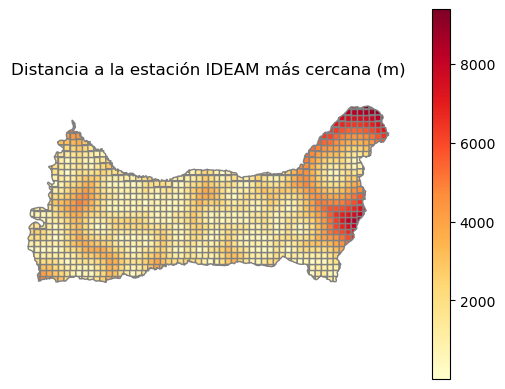

In [8]:
from shapely.geometry import box

# creamos aqui la grilla
def crear_grilla(gdf, cell_size=1000):
    bounds = gdf.total_bounds
    xmin, ymin, xmax, ymax = bounds
    filas = []
    x = xmin
    while x < xmax:
        y = ymin
        while y < ymax:
            c = box(x, y, x + cell_size, y + cell_size)
            filas.append(c)
            y += cell_size
        x += cell_size
    grid = gpd.GeoDataFrame(geometry=filas, crs=gdf.crs)
    grid = gpd.overlay(grid, gdf, how="intersection")
    return grid

rejilla_palmira = crear_grilla(gdf_palmira)
rejilla_palmira['centroide'] = rejilla_palmira.geometry.centroid
centroides = gpd.GeoSeries(rejilla_palmira['centroide'], crs=rejilla_palmira.crs)
# calculamos distancias minimas a estaciones
distancias = centroides.apply(lambda punto: estaciones_palmira.distance(punto).min())
rejilla_palmira['distancia_a_estacion_m'] = distancias
#por ultimo graficamos
rejilla_palmira.plot(column='distancia_a_estacion_m', cmap='YlOrRd', legend=True, edgecolor='grey')
plt.title('Distancia a la estación IDEAM más cercana (m)')
plt.axis('off')
plt.show()

In [9]:
# aqui verificamos que las geometrias de vias y rejillas esten en el mismo sistema de proyección
assert gdf_vias.crs == rejilla_palmira.crs
# corta cada vía por celda
vias_por_celda = gpd.overlay(gdf_vias, rejilla_palmira, how='intersection')
# Longitud en metros de cada segmento de via dentro de cada celda ESTO ES MUY IMPORTANTE
vias_por_celda['longitud_vial'] = vias_por_celda.geometry.length

In [10]:
vias_por_celda

,OBJECTID_1,objectid,key,cod_tramo,codigo_via,pr_inicial,dist_ini,pr_finl,dist_fin,territoria,...,Shape_Leng_2,Shape_Area,Codigo_Mun,num_estaciones,Codigo_Municipio,produccion_total,centroide,distancia_a_estacion_m,geometry,longitud_vial
0,1,388,Primer Orden,25VLB0,25VLB,0,0,14,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4629598.928 1948429.003),1177.429374,"MULTILINESTRING ((4629233.987 1948114.765, 462...",1626.079490
1,1,388,Primer Orden,25VLB0,25VLB,0,0,14,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4629598.928 1949429.003),2174.719712,"MULTILINESTRING ((4629256.007 1948929.003, 462...",2026.351608
2,1,388,Primer Orden,25VLB0,25VLB,0,0,14,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4629598.928 1950429.003),2366.327127,"MULTILINESTRING ((4629155.38 1949929.003, 4629...",2018.237014
3,1,388,Primer Orden,25VLB0,25VLB,0,0,14,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4629598.928 1951429.003),1369.254473,"MULTILINESTRING ((4629191.708 1950929.003, 462...",2080.926467
4,1,388,Primer Orden,25VLB0,25VLB,0,0,14,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4629598.928 1952429.003),387.571352,"MULTILINESTRING ((4629479.405 1951929.003, 462...",2130.897444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,11,595,Primer Orden,2505B0,2505B,0,0,28,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4622598.928 1959429.003),807.699160,"LINESTRING (4623058.169 1958929.003, 4623061.5...",392.927529
151,11,595,Primer Orden,2505B0,2505B,0,0,28,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4623598.928 1959429.003),1466.247008,"LINESTRING (4623098.928 1959319.81, 4623112.97...",751.548043
152,11,595,Primer Orden,2505B0,2505B,0,0,28,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4623598.928 1960429.003),1270.039099,"MULTILINESTRING ((4623481.492 1959929.003, 462...",1666.849562
153,11,595,Primer Orden,2505B0,2505B,0,0,28,0.0,Valle del Cauca,...,2.063917,0.081697,76520,92,76520.0,47379355.0,POINT (4624597.242 1960428.011),1653.067314,"MULTILINESTRING ((4624098.928 1960888.968, 462...",91.206817


Ahora normalizamos ese criterio para combinarlo con los otro como densidad vial.Entonces se  calcula la densidad vial por celda (rejilla) dentro de Palmira. Esto consiste en intersecar cada celda con las vías y sumar la longitud de los segmentos de vía dentro de cada una. Por ende vamos a  calcular la longitud total de vías dentro de cada celda de una rejilla regular en el municipio de Palmira. Primero, se asegura que tanto las capas de vías (gdf_vias) como la rejilla rejilla_palmira estén en el sistema de referencia proyectado EPSG 9377, para que las mediciones de distancia y longitud sean válidas. Luego, se filtran únicamente las vías que intersectan con Palmira, se limpia el índice de la rejilla y se asigna un ID único celda_id a cada celda. A continuación, se realiza una unión espacial sjoin para asignar a cada vía las celdas con las que se intersecta. Se descartan geometrías nulas y se calcula la longitud de cada segmento de vía. Finalmente, se agrupa por celda para sumar la longitud total de vías contenida en cada una. Este resultado permite evaluar la densidad vial local por celda, útil como criterio para análisis espaciales multicriterio.

In [11]:
gdf_vias = gdf_vias.to_crs(epsg=9377)
rejilla_palmira = rejilla_palmira.to_crs(epsg=9377)

vias_palmira = gdf_vias[gdf_vias.intersects(gdf_palmira.geometry.union_all())]
rejilla_palmira = rejilla_palmira.reset_index(drop=True)
rejilla_palmira['celda_id'] = rejilla_palmira.index

vias_por_celda = gpd.sjoin(
    vias_palmira,
    rejilla_palmira[['celda_id', 'geometry']],
    how='left',
    predicate='intersects'
)

vias_por_celda = vias_por_celda[vias_por_celda.geometry.notna()]
vias_por_celda['longitud_vial'] = vias_por_celda.geometry.length

longitudes_por_celda = vias_por_celda.groupby('celda_id')['longitud_vial'].sum().reset_index()

In [12]:
longitudes_por_celda

,celda_id,longitud_vial
0,0,46463.802521
1,6,32583.158351
2,7,32583.158351
3,13,46463.802521
4,20,32583.158351
...,...,...
131,527,14500.086547
132,528,14500.086547
133,541,14500.086547
134,542,14500.086547


In [14]:
rejilla_palmira = rejilla_palmira.drop(columns=['longitud_vial'], errors='ignore')
rejilla_palmira = rejilla_palmira.merge(longitudes_por_celda, on='celda_id', how='left')
rejilla_palmira['longitud_vial'] = rejilla_palmira['longitud_vial'].fillna(0)

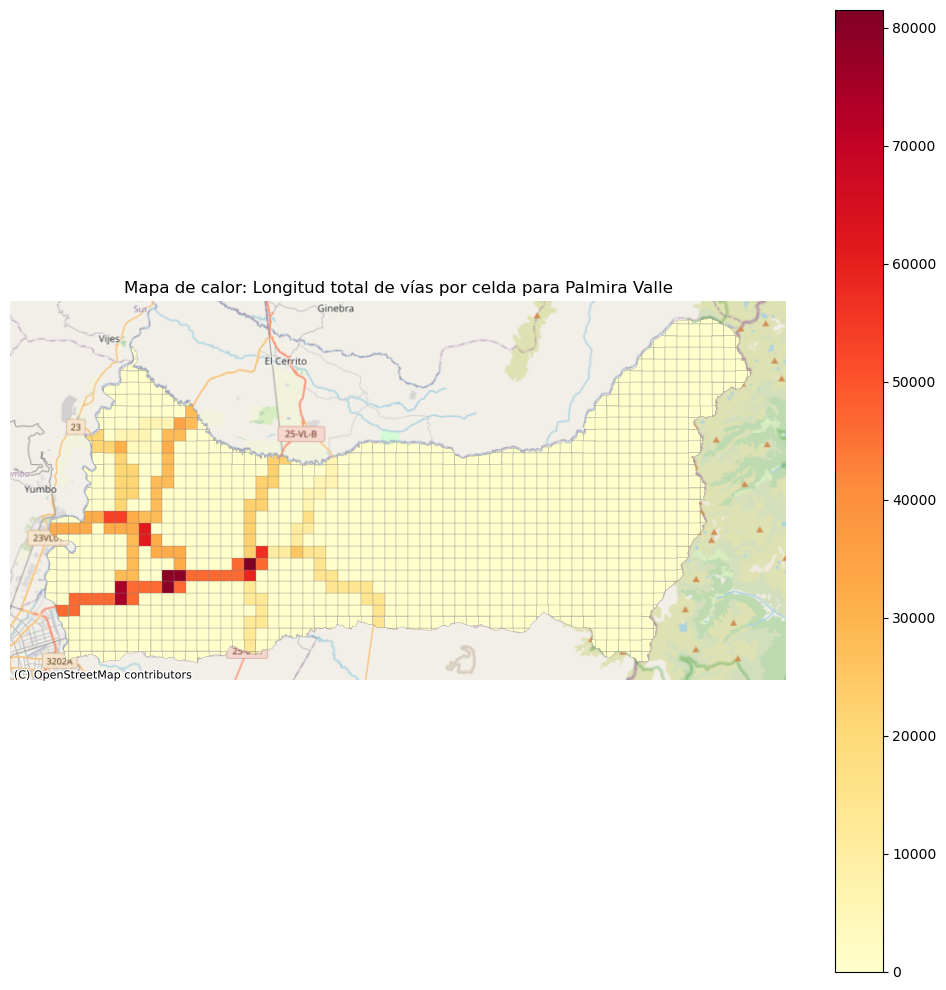

In [20]:
import contextily as ctx
fig, ax = plt.subplots(figsize=(10, 10))
rejilla_palmira.plot(
    column='longitud_vial',     
    cmap='YlOrRd',              
    linewidth=0.2,              
    edgecolor='gray',           
    legend=True,                
    ax=ax
)
# Añadir mapa base
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs=rejilla_palmira.crs)
plt.title("Mapa de calor: Longitud total de vías por celda para Palmira Valle", fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
rejilla_palmira['vial_norm'] = (
    rejilla_palmira['longitud_vial'] - rejilla_palmira['longitud_vial'].min()
) / (
    rejilla_palmira['longitud_vial'].max() - rejilla_palmira['longitud_vial'].min()
)

Este paso es esencial cuando vas a combinar múltiples criterios en un análisis multicriterio, ya que pone todas las variables en la misma escala (0 a 1), permitiendo compararlas o sumarlas con pesos. Para este momento hemos calculado la longitud vial por celda y la normalizaremos, tambien las distancias a estacion por celda y la normalizaremos.Con ello se puede combinarlos en un índice compuesto, seleccionando las mejores celdas acumulando hasta 5 km², y visualizar el mejor polígono.

In [21]:
# normalizamos aqui longitud de vias
rejilla_palmira['vial_norm'] = (
    rejilla_palmira['longitud_vial'] - rejilla_palmira['longitud_vial'].min()
) / (
    rejilla_palmira['longitud_vial'].max() - rejilla_palmira['longitud_vial'].min()
)

#normalizamos distancia aesatcion
rejilla_palmira['distancia_norm'] = 1 - (
    (rejilla_palmira['distancia_a_estacion_m'] - rejilla_palmira['distancia_a_estacion_m'].min()) /
    (rejilla_palmira['distancia_a_estacion_m'].max() - rejilla_palmira['distancia_a_estacion_m'].min())
)
rejilla_palmira['indice_final'] = (
    0.5 * rejilla_palmira['vial_norm'] +
    0.5 * rejilla_palmira['distancia_norm']
)
# Calcular area
rejilla_palmira['area_km2'] = rejilla_palmira.geometry.area / 1e6
#celdas por mejor índice
rejilla_ordenada = rejilla_palmira.sort_values('indice_final', ascending=False)
acumulado = 0
mejores_celdas = []

for idx, row in rejilla_ordenada.iterrows():
    if acumulado + row['area_km2'] <= 5:
        mejores_celdas.append(row)
        acumulado += row['area_km2']
    else:
        break
import geopandas as gpd
mejor_area = gpd.GeoDataFrame(mejores_celdas, crs=rejilla_palmira.crs)

In [22]:
mejor_area

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,produccion_total,geometry,centroide,distancia_a_estacion_m,celda_id,longitud_vial,vial_norm,distancia_norm,indice_final,area_km2
364,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,47379355.0,"POLYGON ((4629098.928 1947929.003, 4629098.928...",POINT (4629598.928198147 1948429.0029276605),1177.429374,364,81519.727101,1.000000,0.875293,0.937646,1.0
238,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,47379355.0,"POLYGON ((4623098.928 1946929.003, 4623098.928...",POINT (4623598.928198147 1947429.0029276605),1780.408805,238,79046.960871,0.969667,0.810992,0.890329,1.0
107,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,47379355.0,"POLYGON ((4618098.928 1944929.003, 4618098.928...",POINT (4618598.928198147 1945429.0029276605),1820.901536,107,74795.749640,0.917517,0.806674,0.862095,1.0
214,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,47379355.0,"POLYGON ((4622098.928 1946929.003, 4622098.928...",POINT (4622598.928198147 1947429.0029276605),2341.452832,214,79046.960871,0.969667,0.751163,0.860415,1.0
363,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,47379355.0,"POLYGON ((4629098.928 1946929.003, 4629098.928...",POINT (4629598.928198147 1947429.0029276605),208.024125,363,59010.260301,0.723877,0.978669,0.851273,1.0


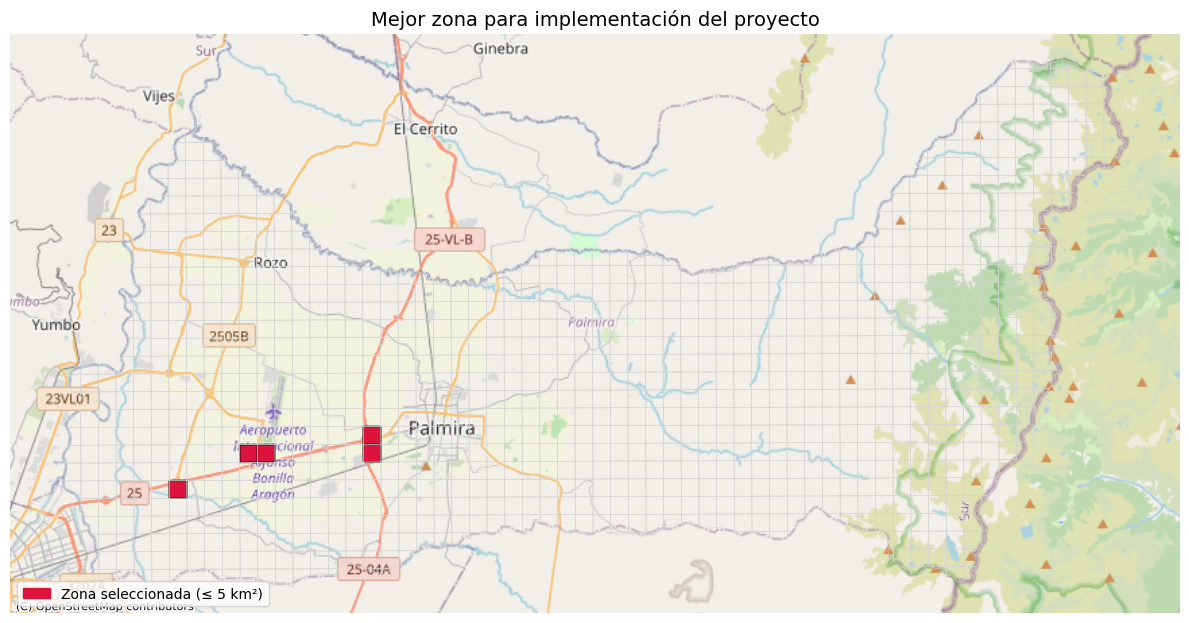

In [30]:
#mapa mejor zona para impl del proyecto ≤ 5 km²
fig, ax = plt.subplots(figsize=(12, 10))

rejilla_web = rejilla_palmira.to_crs(epsg=3857)
mejor_web = mejor_area.to_crs(epsg=3857)
rejilla_web.boundary.plot(ax=ax, color='lightgray', linewidth=0.4)
mejor_web.plot(ax=ax, color='crimson', edgecolor='black')

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
leyenda = [mpatches.Patch(color='crimson', label='Zona seleccionada (≤ 5 km²)')]
ax.legend(handles=leyenda, loc='lower left')
ax.set_title("Mejor zona para implementación del proyecto", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

para seguir con el ejercicio debemos agregar otro criterio local y se escogio el relacionado con las inundaciones, por ende se realizo el mismo porcedimiento, se descargo el shp de drenajes sencillos de Colombia en mapas y se realizo el clip antes de leerse el documento en este trabajo. 

Para ello esta el siguente bloque de código que realiza la selección final de celdas óptimas dentro del municipio de Palmira, excluyendo aquellas que se encuentren cerca de drenajes, los cuales representan zonas de posible riesgo de inundación. Primero, se carga y reproyecta la capa de drenajes y se genera un buffer de 200 metros alrededor de ellos. Luego, se evalúa cada celda de la rejilla  para identificar si intersecta con el buffer de riesgo, y se etiqueta con una columna booleana. A continuación, se filtran solo las celdas seguras que no intersectan el buffer y se ordenan en función de un índice de aptitud indice_final de mayor a menor. Finalmente, se seleccionan iterativamente las mejores celdas hasta acumular un máximo de 5 km², y estas se guardan en un nuevo GeoDataFrame llamado mejor_area, que representa la zona óptima para implementar el proyecto, evitando zonas de riesgo.

In [31]:
#cargamos los drenajes_l
ruta_drenajes = "/notebooks/datos/GIS_Programming_Data/drenajes_l.shp"
gdf_drenajes = gpd.read_file(ruta_drenajes)

#reproyectamos
gdf_drenajes = gdf_drenajes.to_crs(rejilla_palmira.crs)

#creamos buffer de 200 metros 
gdf_buffer = gdf_drenajes.copy()
gdf_buffer['geometry'] = gdf_drenajes.buffer(200)

#marcamos las celdas riesgo qeu estan cerca de los drenajes
rejilla_palmira['cerca_drenaje'] = rejilla_palmira.geometry.apply(
    lambda celda: gdf_buffer.intersects(celda).any()
)
rejilla_filtrada = rejilla_palmira[rejilla_palmira['cerca_drenaje'] == False].copy()
rejilla_ordenada = rejilla_filtrada.sort_values('indice_final', ascending=False)
acumulado = 0
mejores_celdas = []
for idx, row in rejilla_ordenada.iterrows():
    if acumulado + row['area_km2'] <= 5:
        mejores_celdas.append(row)
        acumulado += row['area_km2']
    else:
        break
mejor_area = gpd.GeoDataFrame(mejores_celdas, crs=rejilla_palmira.crs)

In [32]:
mejor_area

,DPTO_CCDGO,MPIO_CCDGO,MPIO_CNMBR,MPIO_CDPMP,VERSION,AREA,LATITUD,LONGITUD,STCTNENCUE,STP3_1_SI,...,geometry,centroide,distancia_a_estacion_m,celda_id,longitud_vial,vial_norm,distancia_norm,indice_final,area_km2,cerca_drenaje
364,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,"POLYGON ((4629098.928 1947929.003, 4629098.928...",POINT (4629598.928198147 1948429.0029276605),1177.429374,364,81519.727101,1.000000,0.875293,0.937646,1.0,False
238,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,"POLYGON ((4623098.928 1946929.003, 4623098.928...",POINT (4623598.928198147 1947429.0029276605),1780.408805,238,79046.960871,0.969667,0.810992,0.890329,1.0,False
107,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,"POLYGON ((4618098.928 1944929.003, 4618098.928...",POINT (4618598.928198147 1945429.0029276605),1820.901536,107,74795.749640,0.917517,0.806674,0.862095,1.0,False
214,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,"POLYGON ((4622098.928 1946929.003, 4622098.928...",POINT (4622598.928198147 1947429.0029276605),2341.452832,214,79046.960871,0.969667,0.751163,0.860415,1.0,False
363,76,520,PALMIRA,76520,2018,1.005153e+09,3.558393,-76.2278,126700.0,0.0,...,"POLYGON ((4629098.928 1946929.003, 4629098.928...",POINT (4629598.928198147 1947429.0029276605),208.024125,363,59010.260301,0.723877,0.978669,0.851273,1.0,False


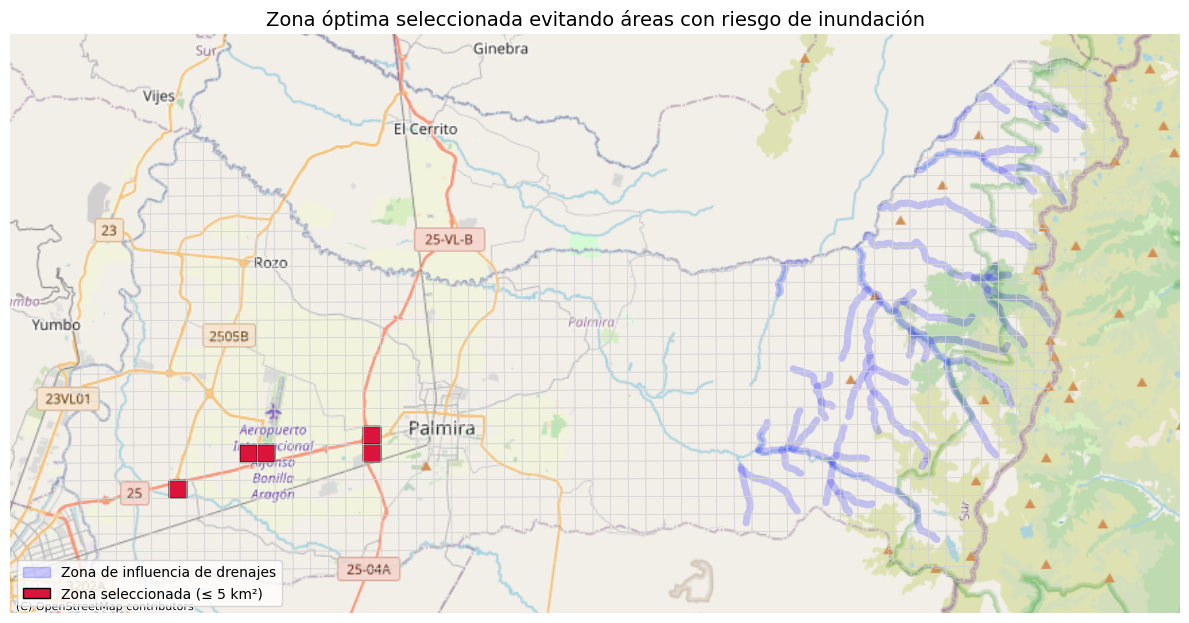

In [34]:
rejilla_web = rejilla_palmira.to_crs(epsg=3857)
mejor_web = mejor_area.to_crs(epsg=3857)
buffer_web = gdf_buffer.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(12, 10))

#rejilla
rejilla_web.boundary.plot(ax=ax, color='lightgray', linewidth=0.4)

#buffer_zona de riesgo
buffer_web.plot(ax=ax, color='blue', alpha=0.2)

#mejor zona seleccionada
mejor_web.plot(ax=ax, color='crimson', edgecolor='black', linewidth=1)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.2, label='Zona de influencia de drenajes'),
    Patch(facecolor='crimson', edgecolor='black', label='Zona seleccionada (≤ 5 km²)')
]
ax.legend(handles=legend_elements, loc='lower left', fontsize=10)

ax.set_title("Zona óptima seleccionada evitando áreas con riesgo de inundación", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

El análisis realizado demuestra que la capa de hidrografía, representada por los drenajes y su zona de influencia definida mediante un buffer de 200 metros, no tuvo una influencia directa y determinante en la selección final de las celdas óptimas para implementar el proyecto debido a que la concentracion de dichos datos hidricos se concentraron en la parte oriental del municipio de Palmira. Sin embargo, las áreas seleccionadas visibles en rojo en el mapa, se localizan exclusivamente fuera de las zonas de riesgo hídrico, lo que puede confirma que el criterio de exclusión por cercanía a drenajes fue aplicado correctamente. Como resultado, la selección se concentró principalmente en la zona occidental del municipio de Palmira, donde la red de drenaje es menos densa. Este patrón sugiere que se priorizaron áreas más seguras frente a inundaciones, lo cual mejora la viabilidad física del proyecto. No obstante, es importante destacar que los datos de hidrografia puede que no sean confiables pero aun asi, que algunas celdas con alto puntaje en el índice de aptitud fueron descartadas automáticamente por su proximidad a drenajes, lo que evidencia el clásico equilibrio en el análisis multicriterio entre minimizar riesgos y maximizar oportunidades. En síntesis, la inclusión de la hidrografía como restricción espacial permitió seleccionar zonas más seguras, pero también limitó geográficamente el conjunto de áreas potencialmente elegibles.

**Resultado**
índice final ahora considera 3 criterios locales:
-Alta densidad vial.
-Cercanía a estaciones IDEAM.
-Lejanía de drenajes como proxy de zonas inundables.

**ALIDAS FINALES**
    Mejor municipio seleccionado (Nivel 1)
Ya se hizo el análisis multicriterio a nivel nacional con:
-Número de estaciones IDEAM por municipio.
-Producción total EVA por municipio.
Al no aplicarse pesos, se utiliza un índice simple sumando los criterios normalizados como se evidencia a continuación:

In [35]:
# Normalizar los dos criterios
gdf_municipios['eva_norm'] = (
    gdf_municipios['produccion_total'] - gdf_municipios['produccion_total'].min()
) / (
    gdf_municipios['produccion_total'].max() - gdf_municipios['produccion_total'].min()
)
gdf_municipios['estaciones_norm'] = (
    gdf_municipios['num_estaciones'] - gdf_municipios['num_estaciones'].min()
) / (
    gdf_municipios['num_estaciones'].max() - gdf_municipios['num_estaciones'].min()
)
# Índice combinado
gdf_municipios['indice_nivel1'] = (
    0.5 * gdf_municipios['eva_norm'] + 0.5 * gdf_municipios['estaciones_norm']
)
# Seleccionar el mejor municipio
mejor_mpio = gdf_municipios.sort_values('indice_nivel1', ascending=False).iloc[0]
nombre_mejor_mpio = mejor_mpio['MPIO_CNMBR']
print(f"Mejor municipio seleccionado: {nombre_mejor_mpio}")

Mejor municipio seleccionado: PALMIRA


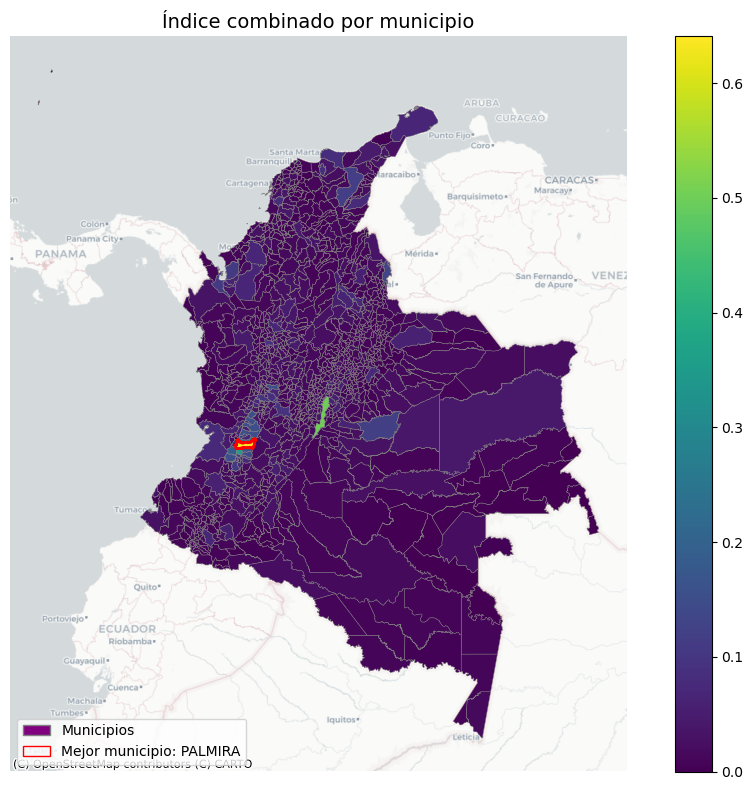

In [42]:
nombre_mejor = "PALMIRA"  # ← asegúrate de que este nombre sea correcto
gdf_municipios_web = gdf_municipios.to_crs(epsg=3857)
fig, ax = plt.subplots(figsize=(10, 8))

gdf_municipios_web.plot(
    ax=ax,
    column='indice_nivel1',
    cmap='viridis',
    edgecolor='gray',
    linewidth=0.3,
    legend=True
)

#mejor municipio
gdf_municipios_web[gdf_municipios_web['MPIO_CNMBR'] == nombre_mejor].plot(
    ax=ax,
    facecolor='none',
    edgecolor='red',
    linewidth=2
)

import contextily as ctx
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='purple', edgecolor='gray', label='Municipios'),
    Patch(facecolor='none', edgecolor='red', label=f'Mejor municipio: {nombre_mejor}')
]
ax.legend(handles=legend_elements, loc='lower left')
ax.set_title("Índice combinado por municipio", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

Para el mapa final con capas intermedias clave obtendremos la siguiente informacion solicitada:
-Rejilla coloreada por índice final.
-Celdas seleccionadas como mejor_area.
-Estaciones IDEAM.
-Drenajes + buffer que en este caso se hizo de 200.
Vías shp Colombia en apas.

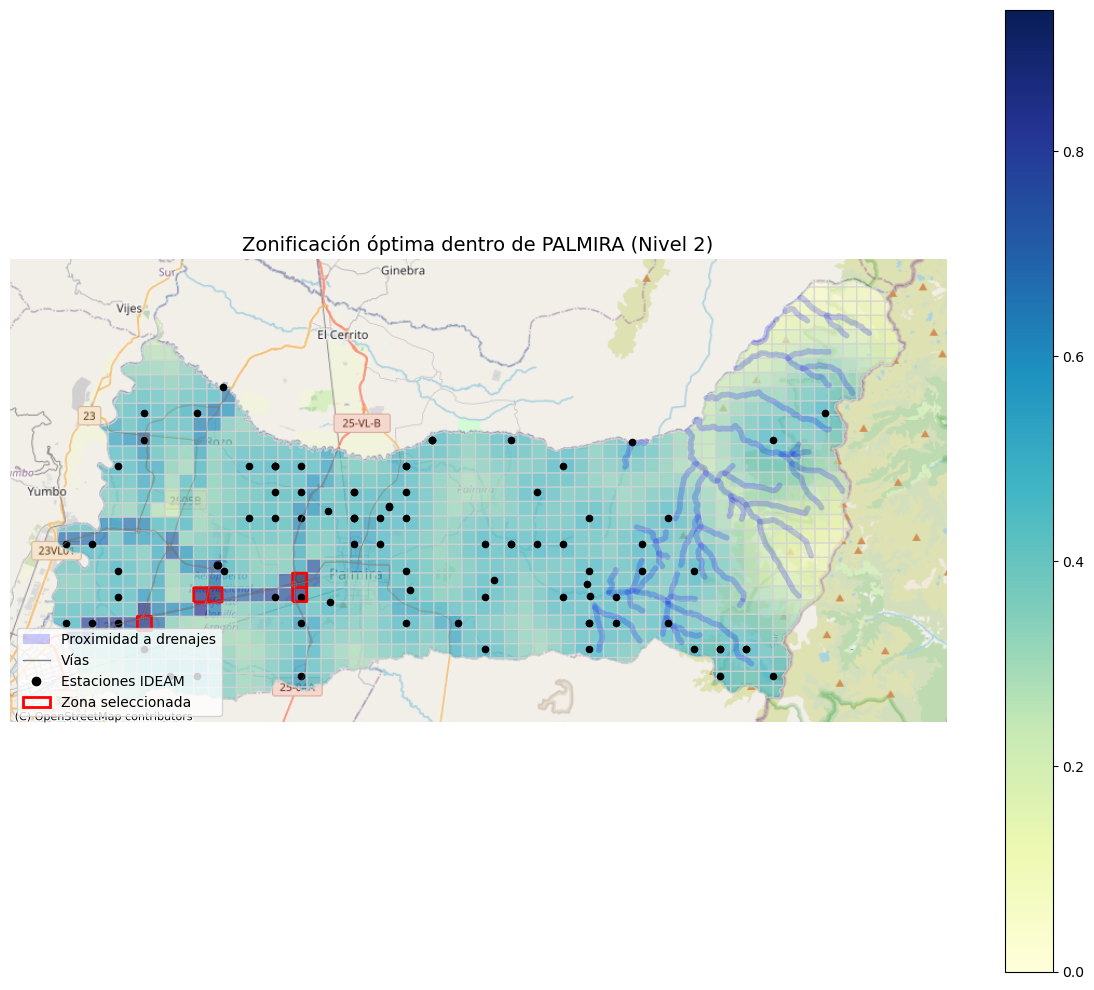

In [44]:
from matplotlib.lines import Line2D
rejilla_web = rejilla_palmira.to_crs(epsg=3857)
buffer_web = gdf_buffer.to_crs(epsg=3857)
estaciones_web = estaciones_palmira.to_crs(epsg=3857)
vias_web = gdf_vias.to_crs(epsg=3857)
mejor_web = mejor_area.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 10))

rejilla_web.plot(
    ax=ax,
    column='indice_final',
    cmap='YlGnBu',
    legend=True,
    edgecolor='lightgray',
    alpha=0.7
)

buffer_web.plot(ax=ax, color='blue', alpha=0.2)
estaciones_web.plot(ax=ax, color='black', markersize=20)
vias_web.plot(ax=ax, color='gray', linewidth=0.5, alpha=0.5)
mejor_web.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
legend_elements = [
    Patch(facecolor='blue', alpha=0.2, label='Proximidad a drenajes'),
    Line2D([0], [0], color='gray', lw=1, label='Vías'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=8, label='Estaciones IDEAM'),
    Patch(facecolor='none', edgecolor='red', linewidth=2, label='Zona seleccionada'),
]

ax.legend(handles=legend_elements, loc='lower left')

ax.set_title(f"Zonificación óptima dentro de {nombre_mejor_mpio} (Nivel 2)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

_**En relación al grafico obtenido que muestra la zonificación óptima  dentro del municipio de Palmira, evitando zonas cercanas a drenajes, maximizando cercanía a estaciones IDEAM, y considerando criterios como densidad vial y productividad agrícola se llego a las siguientes conclusiones:**_

_**El análisis multicriterio permitió identificar el municipio más apto integrando criterios como disponibilidad de infraestructura climática (número de estaciones IDEAM), producción agropecuaria (EVA), densidad vial (Colombia en Mapas) y riesgos asociados a zonas de drenaje (Colombia en Mapas). El resultado fue una selección objetiva del municipio con mejores condiciones para implementar el proyecto en este caso Palmira.**_

_**La zonificación dentro del municipio afinó la toma de decisiones a escala local, aplicando un segundo nivel de análisis para evaluar celdas de 1 km², permitiendo localizar áreas con mayor valor estratégico. Este análisis detallado priorizó celdas con alto valor en el índice combinado y descartó aquellas cercanas a drenajes, reduciendo riesgos potenciales de inundación.**_

_**La integración espacial demostró ser clave en la planificación territorial
El uso de capas como red vial, estaciones meteorológicas, hidrografía y productividad agrícola permitió construir un modelo espacial robusto, en el que las relaciones topológicas y métricas entre los elementos determinaron la selección final de zonas prioritarias.**_

_**El resultado es una zona óptima con condiciones balanceadas de accesibilidad, productividad y bajo riesgo
La zona final seleccionada (≤ 5 km²), claramente representada en el gráfico, se ubica en una región con buena conectividad vial, lejos de zonas de drenaje (por tanto, de posible inundación), y cercana a estaciones climáticas, lo cual la convierte en una opción viable, segura y estratégica para desarrollar el proyecto.**_

